## Text-to-image dreambooth finetuning using transformers specific pipeline component

DreamBooth is a method for personalizing text-to-image models. It fine-tunes these models using 5-10 images of a specific subject, allowing them to generate personalized images based on textual prompts.

This sample shows how to use `diffusers_text_to_image_dreambooth_pipeline` component from the `azureml` system registry to fine tune a model for text to image task using dog Dataset. We then deploy the fine tuned model to an online endpoint for real time inference.

### Training data
We will use the [dog-example](https://huggingface.co/datasets/diffusers/dog-example) dataset.

### Model
We will use the `runwayml-stable-diffusion-v1-5` model in this notebook. If you need to fine tune a model that is available on HuggingFace, but not available in `azureml` system registry, you can either register the model and use the registered model or use the `model_name` parameter to instruct the components to pull the model directly from HuggingFace.

### Outline
1. Install dependencies
2. Setup pre-requisites such as compute
3. Pick a model to fine tune
4. Prepare dataset for finetuning the model
5. Submit the fine tuning job using diffusers specific text-to-image dreambooth fine tuning component
6. Review training metrics
7. Register the fine tuned model
8. Deploy the fine tuned model for real time inference
9. Test deployed end point
9. Clean up resources

### 1. Install dependencies
Before starting off, if you are running the notebook on Azure Machine Learning Studio or running first time locally, you will need the following packages

In [1]:
! pip install azure-ai-ml==1.8.0
! pip install azure-identity==1.13.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 36.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.9/123.9 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.7/270.7 kB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.6/255.6 kB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.9/404.9 kB 18.5 MB/s eta 0:00:00
  Attempting uninstall: azure-storage-blob
    Found existing installation: azure-storage-blob 12.13.0
    Uninstalling azure-storage-blob-12.13.0:
      Successfully uninstalled azure-storage-blob-12.13.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
azureml-mlflow 1.56.0 requires azure-storage-

### 2. Setup pre-requisites

#### 2.1 Connect to Azure Machine Learning workspace

Before we dive in the code, you'll need to connect to your workspace. The workspace is the top-level resource for Azure Machine Learning, providing a centralized place to work with all the artifacts you create when you use Azure Machine Learning.

We are using `DefaultAzureCredential` to get access to workspace. `DefaultAzureCredential` should be capable of handling most scenarios. If you want to learn more about other available credentials, go to [set up authentication doc](https://learn.microsoft.com/en-us/azure/machine-learning/how-to-setup-authentication?tabs=sdk), [azure-identity reference doc](https://learn.microsoft.com/en-us/python/api/azure-identity/azure.identity?view=azure-python).

Replace `AML_WORKSPACE_NAME`, `RESOURCE_GROUP` and `SUBSCRIPTION_ID` with their respective values in the below cell.

In [2]:
from azure.ai.ml import MLClient
from azure.identity import DefaultAzureCredential


experiment_name = "AzureML-Train-Finetune-MultiModal-TextToImage-DreamBooth-Samples"  # can rename to any valid name

credential = DefaultAzureCredential()
workspace_ml_client = None
try:
    workspace_ml_client = MLClient.from_config(credential)
    subscription_id = workspace_ml_client.subscription_id
    resource_group = workspace_ml_client.resource_group_name
    workspace_name = workspace_ml_client.workspace_name
except Exception as ex:
    print(ex)
    # Enter details of your AML workspace
    subscription_id = "c53bdcf6-8fac-491b-8692-9195df094803"
    resource_group = "ChatGPTAOAIteam"
    workspace_name = "slm-innovator"

workspace_ml_client = MLClient(
    credential, subscription_id, resource_group, workspace_name
)
registry_ml_client = MLClient(
    credential,
    subscription_id,
    resource_group,
    registry_name="azureml",
)

Found the config file in: /config.json


#### 2.2 Create compute

In order to finetune a model on Azure Machine Learning studio, you will need to create a compute resource first. **Creating a compute will take 3-4 minutes.** 

For additional references, see [Azure Machine Learning in a Day](https://github.com/Azure/azureml-examples/blob/main/tutorials/azureml-in-a-day/azureml-in-a-day.ipynb). 

In [3]:
from azure.ai.ml.entities import AmlCompute
from azure.core.exceptions import ResourceNotFoundError

cluster_name = "sample-finetune-cluster-gpu"

try:
    _ = workspace_ml_client.compute.get(cluster_name)
    print("Found existing compute target.")
except ResourceNotFoundError:
    print("Creating a new compute target...")
    compute_config = AmlCompute(
        name=cluster_name,
        type="amlcompute",
        size="Standard_NC6s_v3",
        idle_time_before_scale_down=120,
        min_instances=0,
        max_instances=4,
    )
    workspace_ml_client.begin_create_or_update(compute_config).result()

Creating a new compute target...


### 3. Pick a foundation model to fine tune

We will use the `runwayml-stable-diffusion-v1-5` model in this notebook. If you need to fine tune a model that is available on HuggingFace, but not available in `azureml` system registry, you can either register the model and use the registered model or provide huggingface model_id in the `model_name` parameter to instruct the components to pull the model directly from HuggingFace.

Currently following models are supported:

| Model Name | Source |
| ------ | ---------- |
| [runwayml-stable-diffusion-v1-5](https://ml.azure.com/registries/azureml/models/runwayml-stable-diffusion-v1-5/version/8) | azureml registry |
| [stabilityai-stable-diffusion-2-1](https://ml.azure.com/registries/azureml/models/stabilityai-stable-diffusion-2-1/version/8) | azureml registry |
| [compvis-stable-diffusion-v1-4](https://ml.azure.com/registries/azureml/models/compvis-stable-diffusion-v1-4/version/8) | azureml registry |
| [Text to Image models from Huggingface's Transformer library](https://huggingface.co/models?pipeline_tag=text-to-image&library=transformers)| HuggingFace |

In [4]:
huggingface_model_name = "runwayml/stable-diffusion-v1-5"

aml_registry_model_name = "runwayml-stable-diffusion-v1-5"
foundation_models = registry_ml_client.models.list(aml_registry_model_name)
foundation_model = max(foundation_models, key=lambda x: int(x.version))
print(
    f"\n\nUsing model name: {foundation_model.name}, version: {foundation_model.version}, id: {foundation_model.id} for fine tuning"
)



Using model name: runwayml-stable-diffusion-v1-5, version: 12, id: azureml://registries/azureml/models/runwayml-stable-diffusion-v1-5/versions/12 for fine tuning


### 4. Prepare the dataset for fine-tuning the model

We will use the [dog-example](https://huggingface.co/datasets/diffusers/dog-example) dataset. It consists of 5 dog images.

#### 4.1 Download the Data

For dreambooth training, we need few images in the folder. We will download the dog-example dataset locally.

In [5]:
import json
import requests
import os

url = "https://datasets-server.huggingface.co/rows?dataset=diffusers%2Fdog-example&config=default&split=train&offset=0&length=100"
dataset_dir = "dog-example"

response = requests.get(url)
response.raise_for_status()

# Parse the JSON content
data = json.loads(response.content)
data = data["rows"]
# Create a directory for the images
os.makedirs(dataset_dir, exist_ok=True)

# Iterate over the parsed data and download each image
for i, item in enumerate(data):
    image_url = item["row"]["image"]["src"]
    image_response = requests.get(image_url)

    # Check if the request was successful
    image_response.raise_for_status()

    # Write the image data to a file
    with open(os.path.join(dataset_dir, f"image_{i}.jpeg"), "wb") as f:
        f.write(image_response.content)

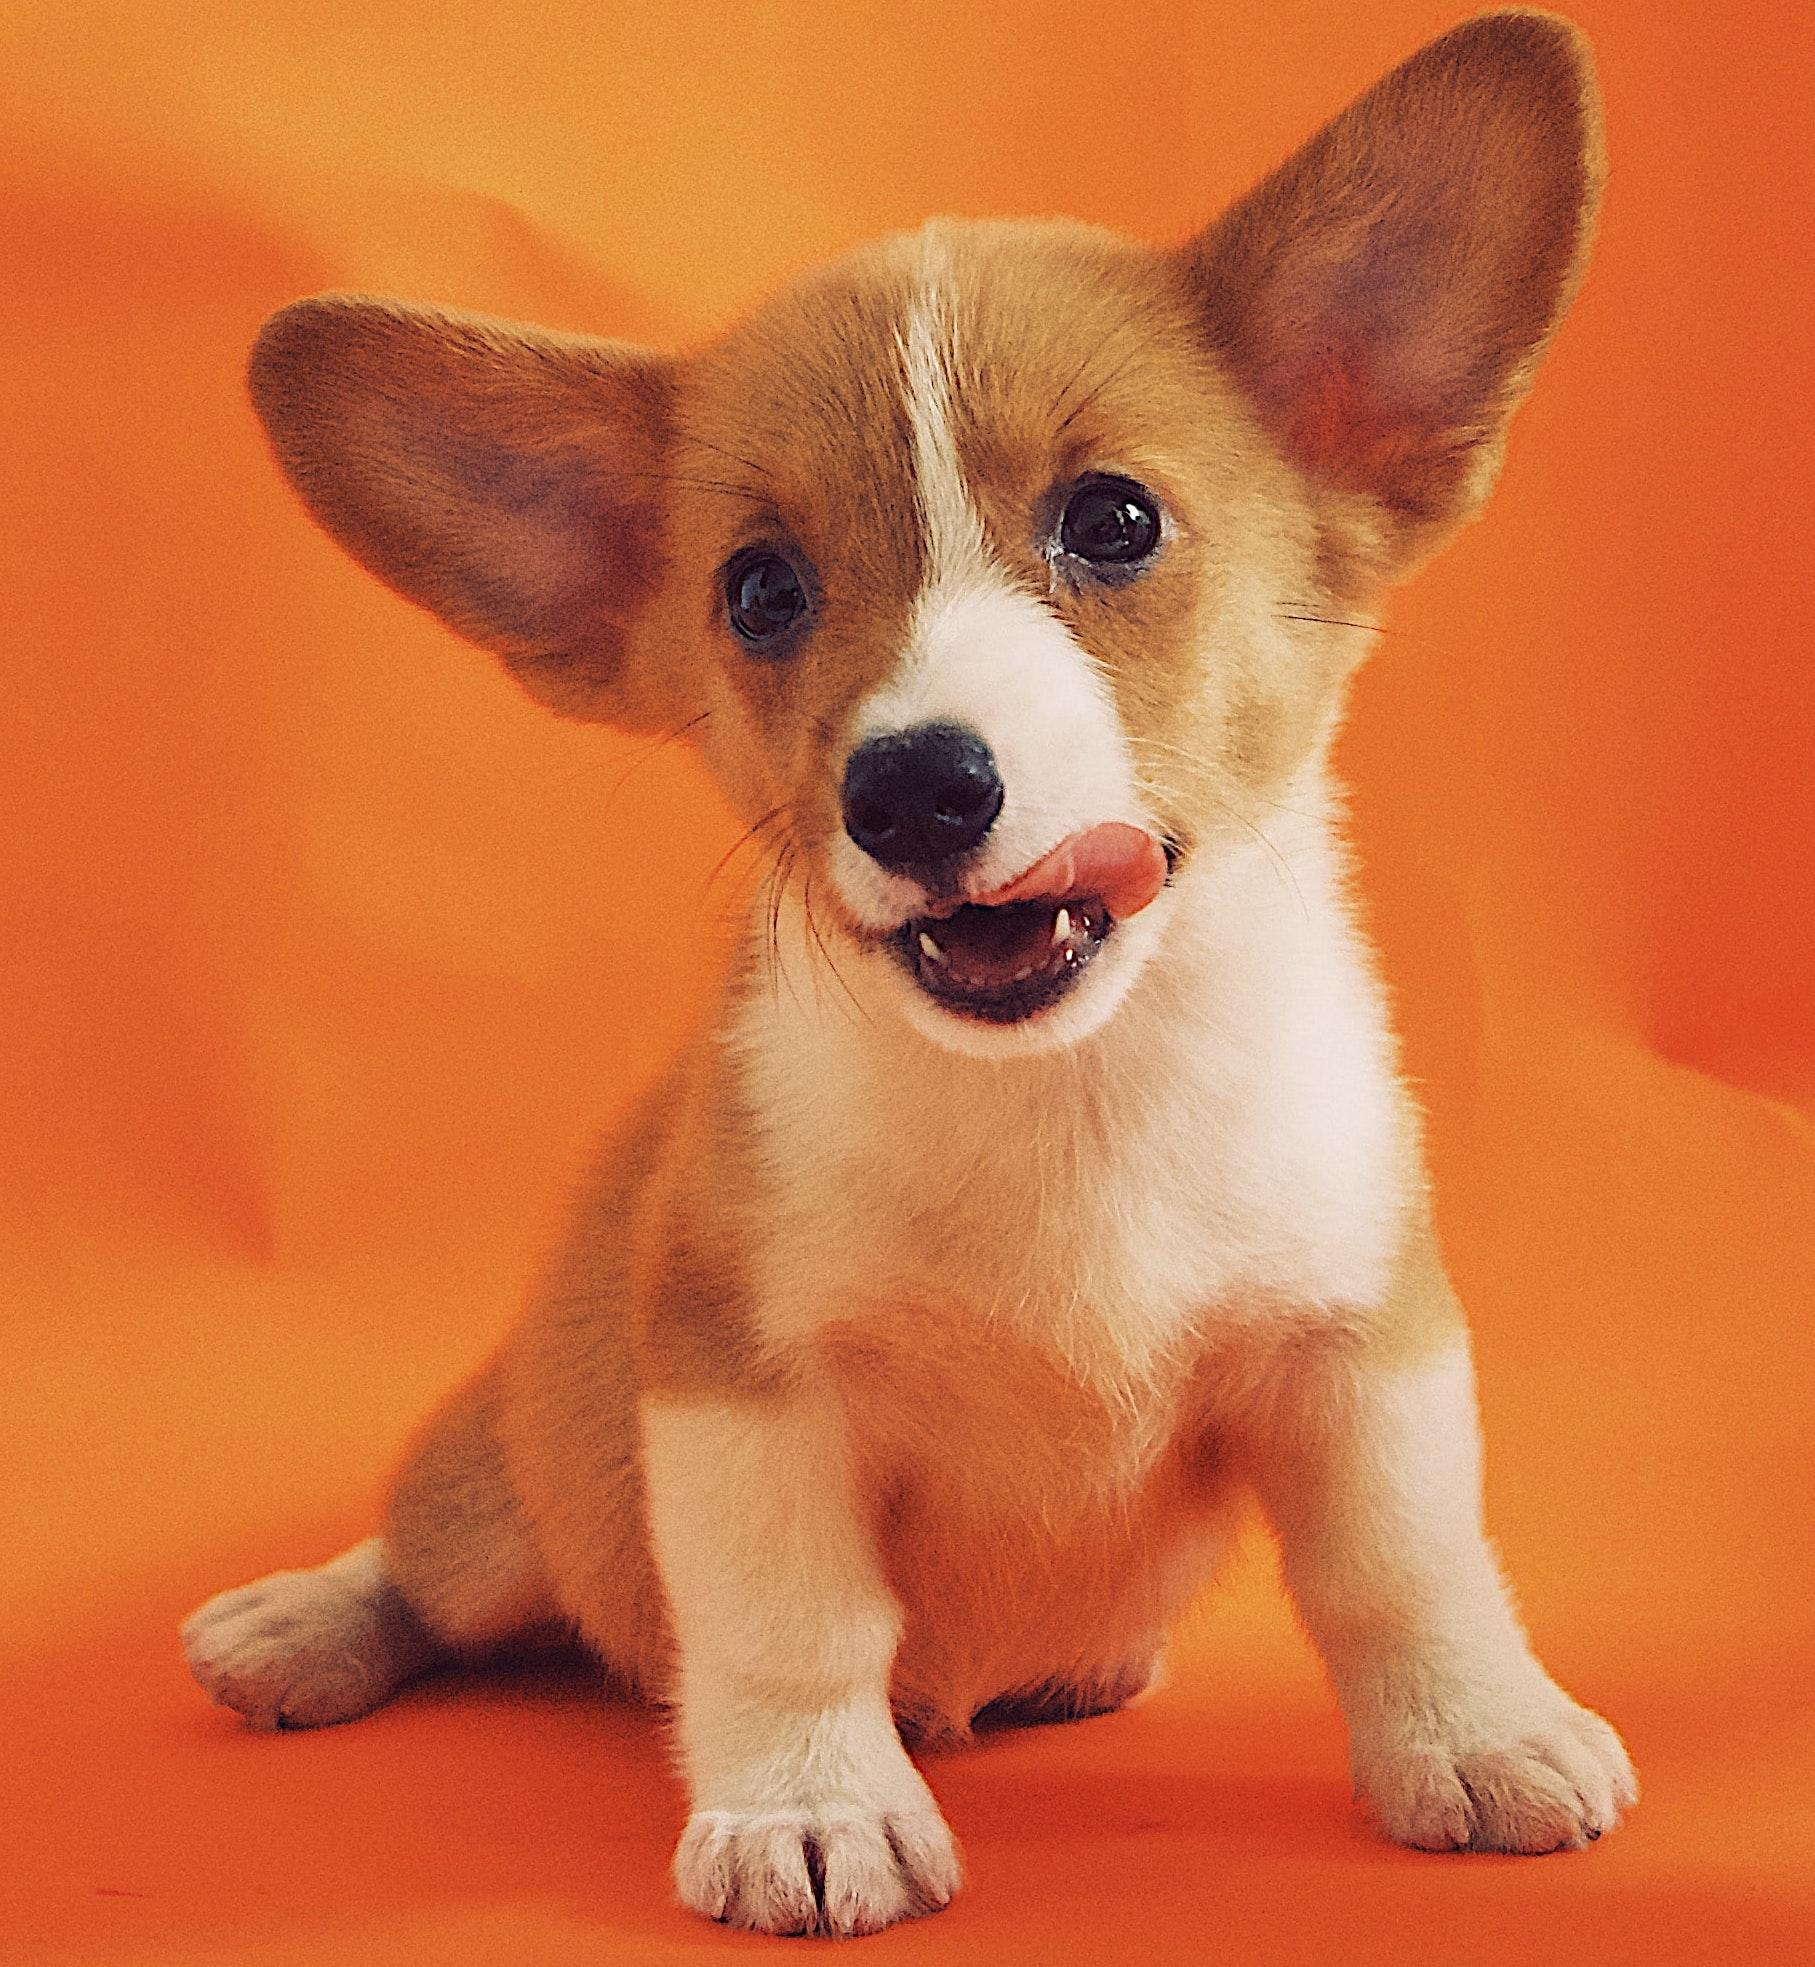

In [6]:
import os
from IPython.display import Image

files = os.listdir(dataset_dir)
image_file = [file for file in files if file.endswith((".jpg", ".jpeg", ".png"))][0]
sample_image = os.path.join(dataset_dir, image_file)
Image(filename=sample_image, width=400, height=400)

#### 4.2 Upload the images to Datastore through an AML Data asset (URI Folder)

In order to use the data for training in Azure ML, we upload it to our default Azure Blob Storage of our  Azure ML Workspace.

In [7]:
# Uploading image files by creating a 'data asset URI FOLDER':

from azure.ai.ml.entities import Data
from azure.ai.ml.constants import AssetTypes

instance_data = Data(
    path=dataset_dir,
    type=AssetTypes.URI_FOLDER,
    description="Dog images for text to image dreambooth training",
    name="dog-images-text-to-image",
)

instance_data_uri_folder = workspace_ml_client.data.create_or_update(instance_data)

print(instance_data_uri_folder)
print("")
print("Path to folder in Blob Storage:")
print(instance_data_uri_folder.path)

Uploading dog-example (4.41 MBs): 100%|██████████| 4409251/4409251 [00:00<00:00, 31307592.22it/s]




creation_context:
  created_at: '2024-09-01T15:43:13.364436+00:00'
  created_by: "(MZC MTC AOAI \uD300) SITHUKAUNG SET"
  created_by_type: User
  last_modified_at: '2024-09-01T15:43:13.373277+00:00'
description: Dog images for text to image dreambooth training
id: /subscriptions/c53bdcf6-8fac-491b-8692-9195df094803/resourceGroups/chatgptaoaiteam/providers/Microsoft.MachineLearningServices/workspaces/slm-innovator/data/dog-images-text-to-image/versions/1
name: dog-images-text-to-image
path: azureml://subscriptions/c53bdcf6-8fac-491b-8692-9195df094803/resourcegroups/chatgptaoaiteam/workspaces/slm-innovator/datastores/workspaceblobstore/paths/LocalUpload/a2341fde44d19341109f2a0e9271c0f1/dog-example/
properties: {}
tags: {}
type: uri_folder
version: '1'


Path to folder in Blob Storage:
azureml://subscriptions/c53bdcf6-8fac-491b-8692-9195df094803/resourcegroups/chatgptaoaiteam/workspaces/slm-innovator/datastores/workspaceblobstore/paths/LocalUpload/a2341fde44d19341109f2a0e9271c0f1/dog-exam

### 5. Submit the fine tuning job using `diffusers_text_to_image_dreambooth_pipeline` component
 
Create the job that uses the `diffusers_text_to_image_dreambooth_pipeline` component for `stable-diffusion-text-to-image` task. Learn more in 5.2 about all the parameters supported for fine tuning.

#### 5.1 Get pipeline component

In [8]:
FINETUNE_PIPELINE_COMPONENT_NAME = "diffusers_text_to_image_dreambooth_pipeline"

pipeline_component_transformers_func = registry_ml_client.components.get(
    name=FINETUNE_PIPELINE_COMPONENT_NAME, label="latest"
)

#### 5.2 Create arguments to be passed to `diffusers_text_to_image_dreambooth_pipeline` component

The `diffusers_text_to_image_dreambooth_pipeline` component consists of model selection and finetuning components.

*Uncomment one or more parameters below to provide specific values, if you wish you override the autoselected default values. Please visit this pipeline component in Azure ML studio to know more about arguments and their allowed values.*

In [9]:
pipeline_component_args = {
    # # Model import args
    "model_family": "HuggingFaceImage",
    "download_from_source": False,  # True for downloading a model directly from HuggingFace
    "mlflow_model": foundation_model.id,  # foundation_model.id is provided, only foundation_model gives UserErrorException: only path input is supported now but get: ...
    # "model_name": huggingface_model_name, # specify the model_name instead of mlflow_model if you want to use a model from the huggingface hub
    # # Finetune_args
    "task_name": "stable-diffusion-text-to-image",
    # # Instance prompt - The instance_prompt argument is a text prompt that contains a unique identifier, such as sks, and the class the image belongs to.
    "instance_prompt": '"A photo of a sks dog"',  # Please note that we need to escape the double inverted comma.
    "resolution": 512,
    # # Prior preservation loss
    "with_prior_preservation": True,
    # Class prompt - a prompt without the unique identifier. This prompt is used for generating "class images" for prior preservation
    "class_prompt": '"a photo of dog"',  # Please note that we need to escape the double inverted comma.
    "num_class_images": 100,  # Number of images to generate with the class prompt for prior preservation.
    "class_data_dir": None,  # Specify Datastore URI of existing uri_folder containing class images if you have, and the training job will generate any additional images so that num_class_images are present in class_data_dir during training time.
    "prior_generation_precision": "fp32",
    "prior_loss_weight": 1.0,
    "sample_batch_size": 2,  # Number of samples to generate class images in each batch.
    # # Lora parameters
    # # LoRA reduces the number of trainable parameters by learning pairs of rank-decompostion matrices while freezing the original weights. This vastly reduces the storage requirement for large models adapted to specific tasks and enables efficient task-switching during deployment all without introducing inference latency. LoRA also outperforms several other adaptation methods including adapter, prefix-tuning, and fine-tuning.
    "apply_lora": True,
    # "lora_alpha": 128,
    # "lora_r": 16,
    # "lora_dropout": 0.0,
    # "tokenizer_max_length": 77,
    # # Text Encoder
    "pre_compute_text_embeddings": True,
    "train_text_encoder": False,
    # "text_encoder_type": "CLIPTextModel",
    # "text_encoder_name": "openai/clip-vit-base-patch32", # Huggingface id of text encoder.
    # "text_encoder_use_attention_mask": False,
    # # UNET related
    # "class_labels_conditioning": "timesteps",
    # # Noise Scheduler
    "noise_scheduler_name": "DDPMScheduler",  # Optional, default is used from the base model. If following scheduler related parameters are not provided, it is taken from model's scheduler config.
    # "noise_scheduler_num_train_timesteps": 1000,
    # "noise_scheduler_variance_type": "fixed_small",
    # "noise_scheduler_prediction_type": "epsilon",
    # "noise_scheduler_timestep_spacing": "leading",
    # "extra_noise_scheduler_args": "clip_sample_range=1.0; clip_sample=True" # Optional additional arguments that are supplied to noise scheduler. The arguments should be semi-colon separated key value pairs and should be enclosed in double quotes.
    # "offset_noise": False
    # # Training related
    "num_validation_images": 3,  # Number of images to generate using instance_prompt. Images are stored in the output/checkpoint-* directories. Please note that this will increase the training time.
    "number_of_workers": 3,
    "number_of_epochs": 15,
    "max_steps": -1,
    "training_batch_size": 3,
    "auto_find_batch_size": False,
    "learning_rate": 1e-4,  # Learning rate is recommended to be set to a lower value, if not fine-tuning with Lora
    # "learning_rate_scheduler": "warmup_linear",
    # "warmup_steps": 0,
    # "optimizer": "adamw_hf",
    # "weight_decay": 0.0,
    # "gradient_accumulation_step": 1,
    # "max_grad_norm": 1.0,
    "precision": "32",
    "random_seed": 42,
    "logging_strategy": "epoch",
    # "logging_steps": 500,  # Number of update steps between two logs if logging_strategy='steps'.
    "save_total_limit": -1,  # If you face issues related to disk space, you can limit the number of checkpoints saved.
    "save_as_mlflow_model": True,
}

In [10]:
process_count_per_instance = 1  # Number of gpus to be used per node for finetuning, should be equal to number of gpu per node in the compute SKU used for finetune
instance_count = (
    1  # Number of nodes to be used for finetuning (used for distributed training)
)

In [11]:
# Ensure that the user provides only one of mlflow_model or model_name
if (
    pipeline_component_args.get("mlflow_model") is None
    and pipeline_component_args.get("model_name") is None
):
    raise ValueError(
        "You must specify either mlflow_model or model_name for the model to finetune"
    )
if (
    pipeline_component_args.get("mlflow_model") is not None
    and pipeline_component_args.get("model_name") is not None
):
    raise ValueError(
        "You must specify ONLY one of mlflow_model and model_name for the model to finetune"
    )
elif (
    pipeline_component_args.get("mlflow_model") is None
    and pipeline_component_args.get("model_name") is not None
):
    use_model_name = huggingface_model_name
elif (
    pipeline_component_args.get("mlflow_model") is not None
    and pipeline_component_args.get("model_name") is None
):
    use_model_name = aml_registry_model_name
print(f"Finetuning model {use_model_name}")

Finetuning model runwayml-stable-diffusion-v1-5


#### 5.3 Utility function to create pipeline using `diffusers_text_to_image_dreambooth_pipeline` component

In [12]:
from azure.ai.ml.dsl import pipeline
from azure.ai.ml.entities import PipelineComponent
from azure.ai.ml import Input
from azure.ai.ml.constants import AssetTypes


@pipeline()
def create_pipeline_transformers():
    """Create pipeline."""

    diffusers_pipeline_component: PipelineComponent = (
        pipeline_component_transformers_func(
            compute_model_import=cluster_name,
            compute_finetune=cluster_name,
            instance_data_dir=Input(
                type=AssetTypes.URI_FOLDER, path=instance_data_uri_folder.path
            ),
            process_count_per_instance=process_count_per_instance,
            instance_count=instance_count,
            **pipeline_component_args,
        )
    )
    return {
        # Map the output of the fine tuning job to the output of pipeline job so that we can easily register the fine tuned model. Registering the model is required to deploy the model to an online or batch endpoint.
        "trained_model": diffusers_pipeline_component.outputs.mlflow_model_folder,
    }

#### 5.4 Run the fine tuning job

In [13]:
diffusers_pipeline_object = create_pipeline_transformers()

# don't use cached results from previous jobs
diffusers_pipeline_object.settings.force_rerun = True

# set continue on step failure to False
diffusers_pipeline_object.settings.continue_on_step_failure = False


diffusers_pipeline_object.display_name = (
    use_model_name + "_diffusers_pipeline_component_run_" + "text2image"
)
# Don't use cached results from previous jobs
diffusers_pipeline_object.settings.force_rerun = True

print("Submitting pipeline")

diffusers_pipeline_run = workspace_ml_client.jobs.create_or_update(
    diffusers_pipeline_object, experiment_name=experiment_name
)

print(f"Pipeline created. URL: {diffusers_pipeline_run.studio_url}")

Class AutoDeleteSettingSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class AutoDeleteConditionSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class BaseAutoDeleteSettingSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class IntellectualPropertySchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class ProtectionLevelSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class BaseIntellectualPropertySchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.


Submitting pipeline


pathOnCompute is not a known attribute of class <class 'azure.ai.ml._restclient.v2023_04_01_preview.models._models_py3.MLFlowModelJobOutput'> and will be ignored


Pipeline created. URL: https://ml.azure.com/runs/gentle_avocado_l8d0pyq023?wsid=/subscriptions/c53bdcf6-8fac-491b-8692-9195df094803/resourcegroups/chatgptaoaiteam/workspaces/slm-innovator&tid=4aed9820-113d-4f48-9f53-4d91f37ad279


In [14]:
diffusers_pipeline_run

Experiment,Name,Type,Status,Details Page
AzureML-Train-Finetune-MultiModal-TextToImage-DreamBooth-Samples,gentle_avocado_l8d0pyq023,pipeline,NotStarted,Link to Azure Machine Learning studio


In [15]:
workspace_ml_client.jobs.stream(diffusers_pipeline_run.name)

RunId: gentle_avocado_l8d0pyq023
Web View: https://ml.azure.com/runs/gentle_avocado_l8d0pyq023?wsid=/subscriptions/c53bdcf6-8fac-491b-8692-9195df094803/resourcegroups/chatgptaoaiteam/workspaces/slm-innovator

Streaming logs/azureml/executionlogs.txt

[2024-09-01 15:43:50Z] Submitting 1 runs, first five are: c909468e:cd75006d-888a-40ef-b4f0-b217c18b16fd
[2024-09-01 16:50:03Z] Completing processing run id cd75006d-888a-40ef-b4f0-b217c18b16fd.

Execution Summary
RunId: gentle_avocado_l8d0pyq023
Web View: https://ml.azure.com/runs/gentle_avocado_l8d0pyq023?wsid=/subscriptions/c53bdcf6-8fac-491b-8692-9195df094803/resourcegroups/chatgptaoaiteam/workspaces/slm-innovator



### 6. Get metrics from finetune component

The model training happens as part of the finetune component. Please follow below steps to extract validation metrics from the run.

##### 6.1 Initialize MLFlow Client

The models and artifacts that are produced by AutoML can be accessed via the MLFlow interface.
Initialize the MLFlow client here, and set the backend as Azure ML, via. the MLFlow Client.

IMPORTANT - You need to have installed the latest MLFlow packages with:

    pip install azureml-mlflow
    pip install mlflow

In [16]:
import mlflow

# Obtain the tracking URL from MLClient
MLFLOW_TRACKING_URI = workspace_ml_client.workspaces.get(
    name=workspace_ml_client.workspace_name
).mlflow_tracking_uri

print(MLFLOW_TRACKING_URI)

azureml://koreacentral.api.azureml.ms/mlflow/v1.0/subscriptions/c53bdcf6-8fac-491b-8692-9195df094803/resourceGroups/ChatGPTAOAIteam/providers/Microsoft.MachineLearningServices/workspaces/slm-innovator


In [17]:
# Set the MLFLOW TRACKING URI
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
print(f"\nCurrent tracking uri: {mlflow.get_tracking_uri()}")


Current tracking uri: azureml://koreacentral.api.azureml.ms/mlflow/v1.0/subscriptions/c53bdcf6-8fac-491b-8692-9195df094803/resourceGroups/ChatGPTAOAIteam/providers/Microsoft.MachineLearningServices/workspaces/slm-innovator


In [18]:
from mlflow.tracking.client import MlflowClient

# Initialize MLFlow client
mlflow_client = MlflowClient()

#### 6.2 Get the training run

In [19]:
# Concat 'tags.mlflow.rootRunId=' and pipeline_job.name in single quotes as filter variable
filter = "tags.mlflow.rootRunId='" + diffusers_pipeline_run.name + "'"
runs = mlflow.search_runs(
    experiment_names=[experiment_name], filter_string=filter, output_format="list"
)

# Get the training and evaluation runs.
# Using a hacky way till 'Bug 2320997: not able to show eval metrics in FT notebooks - mlflow client now showing display names' is fixed
for run in runs:
    # Check if run.data.metrics.epoch exists
    if "epoch" in run.data.metrics:
        training_run = run

#### 6.3 Get training metrics

Access the results (such as Models, Artifacts, Metrics) of a previously completed run.

In [20]:
import pandas as pd

pd.DataFrame(training_run.data.metrics, index=[0]).T

,0
loss,0.230100
grad_norm,0.338502
learning_rate,0.000000
epoch,15.000000
runtime,3.107900
samples_per_second,1.609000
steps_per_second,0.322000
checkpoint_save_step,510.000000
runtime_train,1340.065400
samples_per_second_train,1.119000


### 7. Register the fine tuned model with the workspace

We will register the model from the output of the fine tuning job. This will track lineage between the fine tuned model and the fine tuning job. The fine tuning job, further, tracks lineage to the foundation model, data and training code.

In [21]:
import time

# Generating a unique timestamp that can be used for names and versions that need to be unique
timestamp = str(int(time.time()))

In [22]:
from azure.ai.ml.entities import Model
from azure.ai.ml.constants import AssetTypes

# Check if the `trained_model` output is available
print(
    f"Pipeline job outputs: {workspace_ml_client.jobs.get(diffusers_pipeline_run.name).outputs}"
)

model_path_from_job = (
    f"azureml://jobs/{diffusers_pipeline_run.name}/outputs/trained_model"
)
print(f"Path to register model: {model_path_from_job}")

finetuned_model_name = f"{use_model_name.replace('/', '-')}-dog-text-to-image"
finetuned_model_description = (
    f"{use_model_name.replace('/', '-')} fine tuned model for dog objects text to image"
)
prepare_to_register_model = Model(
    path=model_path_from_job,
    type=AssetTypes.MLFLOW_MODEL,
    name=finetuned_model_name,
    version=timestamp,  # use timestamp as version to avoid version conflict
    description=finetuned_model_description,
)
print(f"Prepare to register model: \n{prepare_to_register_model}")

# Register the model from pipeline job output
registered_model = workspace_ml_client.models.create_or_update(
    prepare_to_register_model
)
print(f"Registered model: {registered_model}")

Pipeline job outputs: {'trained_model': <azure.ai.ml.entities._job.pipeline._io.base.PipelineOutput object at 0x7f3b22ec8700>}
Path to register model: azureml://jobs/gentle_avocado_l8d0pyq023/outputs/trained_model
Prepare to register model: 
description: runwayml-stable-diffusion-v1-5 fine tuned model for dog objects text
  to image
name: runwayml-stable-diffusion-v1-5-dog-text-to-image
path: azureml://jobs/gentle_avocado_l8d0pyq023/outputs/trained_model
properties: {}
tags: {}
type: mlflow_model
version: '1725209427'

Registered model: creation_context:
  created_at: '2024-09-01T16:50:29.567419+00:00'
  created_by: "(MZC MTC AOAI \uD300) SITHUKAUNG SET"
  created_by_type: User
  last_modified_at: '2024-09-01T16:50:29.567419+00:00'
  last_modified_by: "(MZC MTC AOAI \uD300) SITHUKAUNG SET"
  last_modified_by_type: User
description: runwayml-stable-diffusion-v1-5 fine tuned model for dog objects text
  to image
flavors:
  python_function:
    artifacts: "{\n  \"model_artifacts\": {\n   

### 7. Deploy the fine tuned model to an online endpoint
Online endpoints give a durable REST API that can be used to integrate with applications that need to use the model.

In [23]:
import datetime
from azure.ai.ml.entities import ManagedOnlineEndpoint, ManagedOnlineDeployment

# Endpoint names need to be unique in a region, hence using timestamp to create unique endpoint name
online_endpoint_name = "text-to-image-dog-" + datetime.datetime.now().strftime(
    "%m%d%H%M"
)
online_endpoint_description = f"Online endpoint for {registered_model.name}, finetuned for dog text to image generation task."
# Create an online endpoint
endpoint = ManagedOnlineEndpoint(
    name=online_endpoint_name,
    description=online_endpoint_description,
    auth_mode="key",
    tags={"foo": "bar"},
)
workspace_ml_client.begin_create_or_update(endpoint).result()

ManagedOnlineEndpoint({'public_network_access': 'Enabled', 'provisioning_state': 'Succeeded', 'scoring_uri': 'https://text-to-image-dog-09011650.koreacentral.inference.ml.azure.com/score', 'openapi_uri': 'https://text-to-image-dog-09011650.koreacentral.inference.ml.azure.com/swagger.json', 'name': 'text-to-image-dog-09011650', 'description': 'Online endpoint for runwayml-stable-diffusion-v1-5-dog-text-to-image, finetuned for dog text to image generation task.', 'tags': {'foo': 'bar'}, 'properties': {'createdBy': '(MZC MTC AOAI 팀) SITHUKAUNG SET', 'createdAt': '2024-09-01T16:50:35.041702+0000', 'lastModifiedAt': '2024-09-01T16:50:35.041702+0000', 'azureml.onlineendpointid': '/subscriptions/c53bdcf6-8fac-491b-8692-9195df094803/resourcegroups/chatgptaoaiteam/providers/microsoft.machinelearningservices/workspaces/slm-innovator/onlineendpoints/text-to-image-dog-09011650', 'AzureAsyncOperationUri': 'https://management.azure.com/subscriptions/c53bdcf6-8fac-491b-8692-9195df094803/providers/Mic

In [30]:

from azure.ai.ml.entities import OnlineRequestSettings, ProbeSettings

deployment_name = "text2img-dog-mlflow-deploy"

# Create a deployment
demo_deployment = ManagedOnlineDeployment(
    name=deployment_name,
    endpoint_name=online_endpoint_name,
    model=registered_model.id,
    instance_type="Standard_NC6s_v3",
    instance_count=1,
    request_settings=OnlineRequestSettings(
        max_concurrent_requests_per_instance=1,
        request_timeout_ms=90000,
        max_queue_wait_ms=500,
    ),
    liveness_probe=ProbeSettings(
        failure_threshold=49,
        success_threshold=1,
        timeout=299,
        period=180,
        initial_delay=180,
    ),
    readiness_probe=ProbeSettings(
        failure_threshold=10,
        success_threshold=1,
        timeout=10,
        period=10,
        initial_delay=2000,
    ),
)
workspace_ml_client.online_deployments.begin_create_or_update(demo_deployment).wait()
endpoint.traffic = {deployment_name: 100}
workspace_ml_client.begin_create_or_update(endpoint).result()

Check: endpoint text-to-image-dog-09011650 exists


.

### 8. Test the endpoint with sample data


In [28]:
# Create request json
import json

request_json = {
    "input_data": {
        "columns": ["prompt"],
        "index": [0],
        "data": ["a photo of sks dog in a bucket"],
    },
    "params": {
        "height": 512,
        "width": 512,
        "num_inference_steps": 50,
        "guidance_scale": 7.5,
        "negative_prompt": ["blurry; three legs"],
        "num_images_per_prompt": 2,
    },
}

request_file_name = "sample_request_data.json"
with open(request_file_name, "w") as request_file:
    json.dump(request_json, request_file)

In [29]:
responses = workspace_ml_client.online_endpoints.invoke(
    endpoint_name=online_endpoint_name,
    deployment_name=deployment_name,
    request_file=request_file_name,
)
responses = json.loads(responses)

ServiceResponseError: ('Connection aborted.', ConnectionResetError(104, 'Connection reset by peer'))

#### Visualize Generated Image(s)
Now that we have scored a test image, we can visualize the generated images.

In [ ]:
import base64
from io import BytesIO
from PIL import Image

for response in responses:
    base64_string = response["generated_image"]
    image_stream = BytesIO(base64.b64decode(base64_string))
    image = Image.open(image_stream)
    display(image)

### 9. Clean up resources - delete the online endpoint
Don't forget to delete the online endpoint, else you will leave the billing meter running for the compute used by the endpoint.

In [ ]:
workspace_ml_client.online_endpoints.begin_delete(name=online_endpoint_name).wait()